In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
import numpy as np

In [163]:
#select two parameters (column_1 and column_2) to regress against price, will also include points
#x_rank is number of top highest of each of the categories
#percentile is cut off at which highest prices are removed

#example:  RegressWines('country', 'variety', 6, 99):
#takes the top 6 countries and top 6 varities and points (score), and removes the retains the bottom 99% of prices in distribution and regresses to predict prices
#column_1 and column_2 can be any of the following ['country', 'designation', 'province', 'variety', 'price', 'winery']

def RegressWines(column_1, column_2, x_ranks, percentile, model_type, alpha_var):

    #import first 150k reviews, and second 130k reviews
    review1 = pd.read_csv(os.path.join('winemag-data_first150k.csv'))
    review2 = pd.read_csv(os.path.join('winemag-data-130k-v2.csv'))

    #concatenate both dataframes by common columns
    review_df = pd.concat([review1, review2], sort=False)
    
#     review_df.to_excel(r'C:\Users\marky\Desktop\LearnPython\RICEHOU201811DATA2\Final-Project/all_prices.xlsx')

    #drop unnamed index columns
    review_df = review_df.drop(['Unnamed: 0'], axis=1)

    #reduce reviews to columns we want to regress against
    model_df = review_df[['country', 'points', 'variety', 'price', 'winery']]

    #drop NaN values
    model_df = model_df.dropna()

    #print total number of starting data points
    print(f"Starting data points for analysis: {len(model_df)}")    
    
    #list top 6 countries
    countries = ['US', 'Italy', 'France', 'Spain', 'Chile', 'Portugal']
    
    #reduce dataframe to contain only six countries
    model_df = model_df[model_df['country'].isin(countries)]
    
    #create list of top 3 wineries in each of top 6 countries
    wineries = []
    for country in countries:
        country_wineries = model_df[model_df['country']==country]['winery'].value_counts().head(3).index.tolist()
        wineries.append(country_wineries)
    
    #create flat list of wineries from list of sublists
    flat_list = [item for sublist in wineries for item in sublist]
    
    #list top x ranked items from column_2 and place in list to train data set
    category_2 = pd.DataFrame(model_df[column_2].value_counts().head(x_ranks))
    category_2 = category_2.index.tolist()

    #reduce dataframe to contain only data points in top x_rank from columns 1 and columns 2 selected
    model_df = model_df.loc[model_df['winery'].isin(flat_list)]
    model_df = model_df.loc[model_df[column_2].isin(category_2)]

    #print remaining number of data points
    print(f"Filtered Data Points: {len(model_df)}") 
    print("-"*60)
    print(column_1)
    print(flat_list)
    print("-"*60)
    print(column_2)
    print(category_2)
    print("-"*60)

    print(f"Starting Max Price = {round(model_df['price'].max(),2)}")

    #max price is definded as percentile cutoff
    max_price = np.percentile(model_df['price'], percentile)
    #remove top (100-percentile) of prices
    model_df = model_df.loc[model_df['price']<= max_price]

    #print new max price
    print(f"New Max Price = {round(model_df['price'].max(), 2)}")
     
    #define X and y parameters
    X = model_df[['points', column_1, column_2]]
    y = model_df["price"].values.reshape(-1, 1)

    #mirror X into data to assign categorical values
    data = X.copy()

    # using get_dummies with a single column
    X = pd.get_dummies(data, columns=[column_1, column_2])

    #define training and testing variables
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_squared_error

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    #scale and transform X and y values
    from sklearn.preprocessing import StandardScaler
    X_scaler = StandardScaler().fit(X_train)
    y_scaler = StandardScaler().fit(y_train)

    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    y_train_scaled = y_scaler.transform(y_train)
    y_test_scaled = y_scaler.transform(y_test)

    
    if model_type=="Linear":
        # Generate the model and fit it to the scaled training data
        from sklearn.linear_model import LinearRegression
        model = LinearRegression()
        model.fit(X_train_scaled, y_train_scaled)
        linear_predictions = model.predict(X_test_scaled)
        MSE = mean_squared_error(y_test_scaled, linear_predictions)
        r2 = model.score(X_test_scaled, y_test_scaled)
        
        graph_x_train = model.predict(X_train_scaled)
        graph_y_train = model.predict(X_train_scaled) - y_train_scaled
        graph_x_test = model.predict(X_test_scaled)
        graph_y_test = model.predict(X_test_scaled) - y_test_scaled
        
    ########LASSO############    

    elif model_type=="Lasso":
        # Note: Use an alpha of .01 when creating the model for this activity
        from sklearn.linear_model import Lasso

        lasso = Lasso(alpha=alpha_var).fit(X_train_scaled, y_train_scaled)
        lasso_predictions = lasso.predict(X_test_scaled)
        
        MSE = mean_squared_error(y_test_scaled, lasso_predictions)
        r2 = lasso.score(X_test_scaled, y_test_scaled)

        graph_x_train = lasso.predict(X_train_scaled)
        graph_y_train = lasso.predict(X_train_scaled) - y_train_scaled[:,0]
        graph_x_test = lasso.predict(X_test_scaled)
        graph_y_test = lasso.predict(X_test_scaled) - y_test_scaled[:,0]
        
    elif model_type=="Ridge":
    # Note: Use an alpha of .01 when creating the model for this activity
        from sklearn.linear_model import Ridge

        ridge = Ridge(alpha=alpha_var).fit(X_train_scaled, y_train_scaled)
        predictions = ridge.predict(X_test_scaled)

        graph_x_train = ridge.predict(X_train_scaled)
        graph_y_train = ridge.predict(X_train_scaled) - y_train_scaled
        graph_x_test = ridge.predict(X_test_scaled)
        graph_y_test = ridge.predict(X_test_scaled) - y_test_scaled
        
        MSE = mean_squared_error(y_test_scaled, predictions)
        r2 = ridge.score(X_test_scaled, y_test_scaled)
        
    elif model_type=="Elastic Net":
        from sklearn.linear_model import ElasticNet

        elasticnet = ElasticNet(alpha=alpha_var).fit(X_train_scaled, y_train_scaled)
        predictions = elasticnet.predict(X_test_scaled)
        MSE = mean_squared_error(y_test_scaled, predictions)
        r2 = elasticnet.score(X_test_scaled, y_test_scaled)

        graph_x_train = elasticnet.predict(X_train_scaled)
        graph_y_train = elasticnet.predict(X_train_scaled) - y_train_scaled[:,0]
        graph_x_test = elasticnet.predict(X_test_scaled)
        graph_y_test = elasticnet.predict(X_test_scaled) - y_test_scaled[:,0]
        
          
        MSE = mean_squared_error(y_test_scaled, predictions)
        r2 = elasticnet.score(X_test_scaled, y_test_scaled)

    plt.scatter(graph_x_train, graph_y_train, c="blue", label="Training Data")
    plt.scatter(graph_x_test, graph_y_test, c="orange", label="Testing Data")
    plt.legend()
    plt.title("Residual Plot")
    plt.show()
    
    print(f"Model Type: {model_type}, MSE: {MSE}, R2: {r2}")  
    
    return plt.hist(model_df['price'])

Starting data points for analysis: 258145
Filtered Data Points: 2738
------------------------------------------------------------
winery
['Williams Selyem', 'Testarossa', 'Chateau Ste. Michelle', 'Feudi di San Gregorio', 'Planeta', 'Tommasi', 'Louis Latour', 'Joseph Drouhin', 'Bouchard Père & Fils', 'Marqués de Cáceres', 'Torres', 'Bodegas Valdemar', 'Concha y Toro', 'Montes', 'Santa Ema', 'DFJ Vinhos', 'Wines & Winemakers', 'Companhia das Quintas']
------------------------------------------------------------
variety
['Pinot Noir', 'Chardonnay', 'Cabernet Sauvignon', 'Red Blend', 'Syrah', 'Bordeaux-style Red Blend']
------------------------------------------------------------
Starting Max Price = 757.0
New Max Price = 757.0


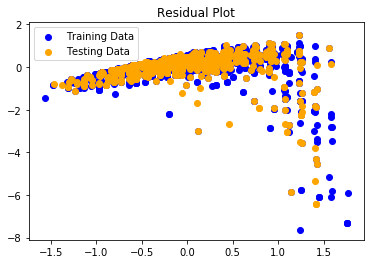

Model Type: Linear, MSE: 0.7105803977539122, R2: 0.38623624610164375


(array([2274.,  323.,   37.,   41.,   29.,    9.,    5.,    6.,    9.,
           5.]),
 array([  7.,  82., 157., 232., 307., 382., 457., 532., 607., 682., 757.]),
 <a list of 10 Patch objects>)

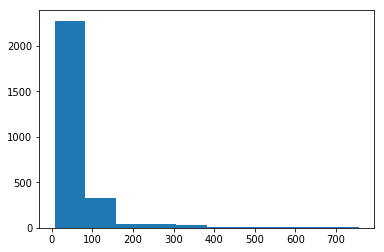

In [165]:
#column_1 and column_2 can be any of the following ['country', 'designation', 'province', 'variety', 'price', 'winery']
#model_type = [Linear, Ridge, Lasso, Elastic Net]
RegressWines('winery', 'variety', 6, 100, "Linear", 0.01)

In [151]:
xdf = RegressWines('winery', 'variety', 10, 100, "Linear", 0.01)

Starting data points for analysis: 258145


In [155]:
xdf[xdf['country']=="Spain"]['winery'].value_counts()

Marqués de Cáceres             133
Torres                         129
Bodegas Valdemar               128
Freixenet                      127
Segura Viudas                  120
CVNE                           113
Sierra Cantabria               107
Telmo Rodríguez                102
Vicente Gandia                  93
Muga                            85
El Coto                         85
Borsao                          81
Ramón Bilbao                    79
Vega Sindoa                     75
Bodegas Navarro López           75
Emilio Moro                     70
González Byass                  68
Bodegas Fariña                  66
Ochoa                           65
Bodegas Palacio                 64
Marques de Griñon               64
Baron De Ley                    63
Marqués de la Concordia         62
Bodegas Dios Baco S.L.          61
García Figuero                  59
Coto de Hayas                   59
Emina                           57
Alta Alella                     56
Bodegas Faustino    